# Part 1: Getting the dataset

In [55]:
import requests
from matplotlib import pyplot as plt
import numpy as np
import csv
import pandas as pd
from pandas import DataFrame
%matplotlib inline

Downloading the dataset and displaying the top rows:

In [2]:
#Storing the dataset as a dictionary (might be useful later on)
data_dict = []
with open('data\sfpd_incidents.csv','rb') as f:
    reader = csv.DictReader(f)
    for line in reader:
        data_dict.append(line)

In [3]:
#Storing the dataset as a Pandas DataFrame
#Easily create DataFrame from list of dictionaries
data_dataframe = DataFrame(data_dict)
data_dataframe.head(5)

,Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,Time,X,Y
0,18TH ST / VALENCIA ST,NON-CRIMINAL,01/19/2015,Monday,LOST PROPERTY,150060275,"(37.7617007179518, -122.42158168137)",MISSION,15006027571000,NONE,14:00,-122.42158168137,37.7617007179518
1,300 Block of LEAVENWORTH ST,ROBBERY,02/01/2015,Sunday,"ROBBERY, BODILY FORCE",150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821003074,NONE,15:45,-122.414406029855,37.7841907151119
2,300 Block of LEAVENWORTH ST,ASSAULT,02/01/2015,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821004014,NONE,15:45,-122.414406029855,37.7841907151119
3,300 Block of LEAVENWORTH ST,SECONDARY CODES,02/01/2015,Sunday,DOMESTIC VIOLENCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821015200,NONE,15:45,-122.414406029855,37.7841907151119
4,LOMBARD ST / LAGUNA ST,VANDALISM,01/27/2015,Tuesday,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",150098226,"(37.8004687042875, -122.431118543788)",NORTHERN,15009822628160,NONE,19:00,-122.431118543788,37.8004687042875


> *The file has may column, and today we'll be working with:*
* The various categories of crimes -> Attribute **Category**
* Crime over the years -> Attribute **Date**
* What time of day do crimes occur? -> Attribute **Time**
* And do certain crime-types tend to happen in specific neighborhoods? -> Attribute **Location**

> *We'll play around with geo-data.*

> * What is the total number of incidents in the CSV file?

In order to get the total number of incidents it's easy to count the different values of `IncidntNum` (it would be probably the same to just count the total number of rows, if `IncidntNum` is a primary key):

In [4]:
total_rows = data_dataframe.count()
print 'Total number of incidents:',total_rows['IncidntNum']

Total number of incidents: 2023865


# Part 2: Working with data

> *The types of crime and their popularity over time. The first field we'll dig into is the column "Category".*
* Create a set() of all the categories of crime in the dataset. How many are there?

In [38]:
num_categories = data_dataframe.Category.nunique()
print 'Total unique categories:',num_categories
all_categories = set()
for data in data_dict:
    all_categories.add(data['Category'])

#Just a check
len(all_categories) == num_categories

Total unique categories: 39


True

> * Now count the number of occurrences of each category in the dataset. What is the most commonly occurring category of crime? What is the least frequently occurring?

Now counting the occurrencies of each category in the dataset: achieved through a simple group by.

In [46]:
categories = data_dataframe.groupby('Category')['Category'].count().reset_index(name="Count")
categories = categories.sort_values(by='Count',ascending=True) #Getting sorted values
categories

,Category,Count
33,TREA,13
22,PORNOGRAPHY/OBSCENE MAT,50
14,GAMBLING,326
29,"SEX OFFENSES, NON FORCIBLE",376
10,EXTORTION,669
3,BRIBERY,732
2,BAD CHECKS,891
11,FAMILY OFFENSES,1128
31,SUICIDE,1197
18,LOITERING,2382


In [47]:
print 'Least occurring category:'
categories.head(1)

Least occurring category:


,Category,Count
33,TREA,13


In [48]:
print 'Most occurring category:'
categories.tail(1)

Most occurring category:


,Category,Count
16,LARCENY/THEFT,422170


> * Create a histogram over crime occurrences.

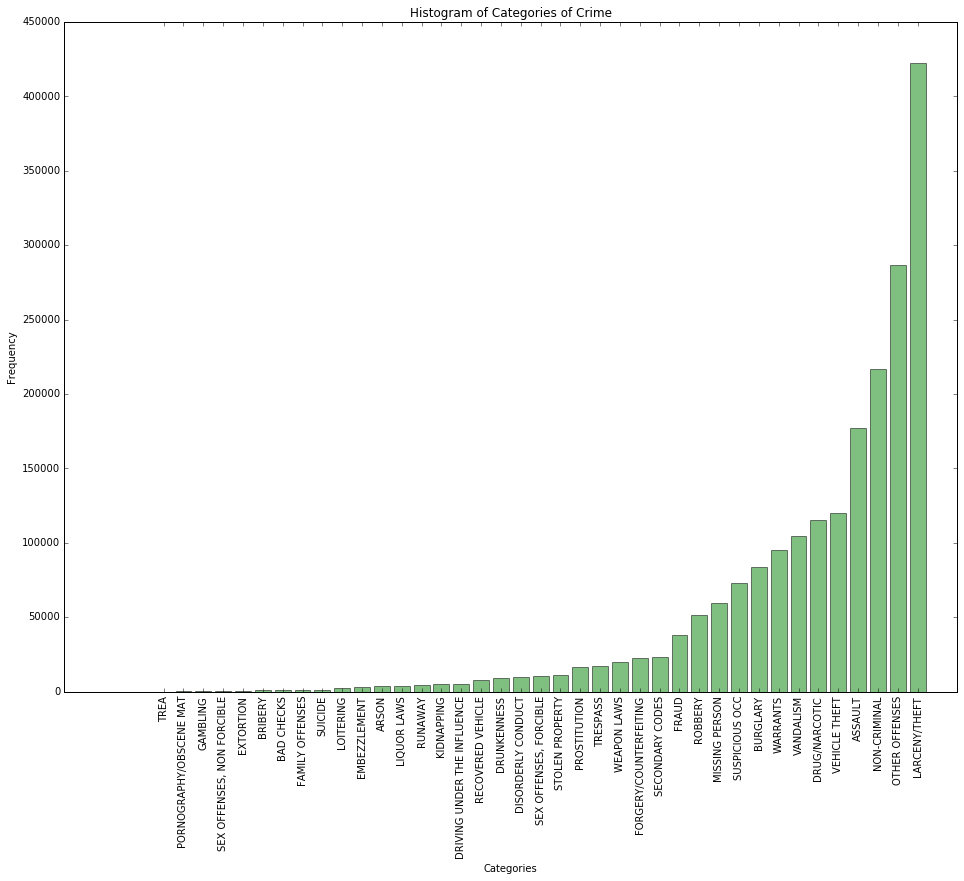

In [74]:
categories_names = list(categories['Category']) # X-ticks labels
y = list(categories['Count']) #Y-values
x = np.arange(len(categories_names)) #X-values

plt.figure(figsize=(16,12))
plt.bar(x,y,alpha=.5,color='green',align='center')
plt.xticks(x,categories_names,rotation='vertical')
plt.title("Histogram of Categories of Crime")
plt.xlabel('Categories')
plt.ylabel("Frequency")
plt.show()

> *Now it's time to explore how the crime statistics change over time. To start off easily, let's count the number of crimes per year for the years 2003-2016 (the full years in the database). What's the average number of crimes per year?*

The basic idea to group by year is to create a new column in the dataset called `Year` and group by this one. In order to do so, it's easy to apply a lambda function (`getYear()`) to extract the year from the already existing `Date` column:

In [97]:
def getYear(date):
    return date.split('/')[2]

#Adding new column in the dataframe
data_dataframe['Year'] = data_dataframe['Date'].apply(lambda x: getYear(x))

#New dataframe with occurrencies of crimes per year
crimes_per_date = data_dataframe.groupby('Year')['Year'].count().reset_index(name='Count')

In [98]:
crimes_per_date

,Year,Count
0,2003,149176
1,2004,148148
2,2005,142186
3,2006,137853
4,2007,137639
5,2008,141311
6,2009,139860
7,2010,133523
8,2011,132697
9,2012,140854
